In [1]:
import findspark
findspark.init()
from pyspark import SparkContext
sc=SparkContext()
sc

<SparkContext master=yarn appName=pyspark-shell>

In [2]:
from pyspark.sql import SparkSession
spark=SparkSession.builder.getOrCreate()
spark

In [3]:
import boto3
import botocore
import pandas as pd
from IPython.display import display, Markdown
from pyspark.sql import SparkSession
from pyspark.sql import Row,DataFrame,Column
from pyspark.sql import SQLContext
from pyspark.sql.functions import col
from pyspark.sql import functions as f


In [4]:
s3 = boto3.client('s3')
s3_resource = boto3.resource('s3')

In [5]:
# reference 
def list_bucket_contents(bucket, match='', size_mb=0):
    bucket_resource = s3_resource.Bucket(bucket)
    total_size_gb = 0
    total_files = 0
    match_size_gb = 0
    match_files = 0
    bucket_list = []
    for key in bucket_resource.objects.all():
        key_size_mb = key.size/1024/1024
        total_size_gb += key_size_mb
        total_files += 1
        list_check = False
        if not match:
            list_check = True
        elif match in key.key:
            list_check = True
        if list_check and not size_mb:
            match_files += 1
            match_size_gb += key_size_mb
            
            print(f'{key.key} ({key_size_mb:3.0f}MB)')
        elif list_check and key_size_mb <= size_mb:
            match_files += 1
            match_size_gb += key_size_mb
            print(f'{key.key} ({key_size_mb:3.0f}MB)')
        
        bucket_list.append(key.key)
    

    if match:
        print(f'Matched file size is {match_size_gb/1024:3.1f}GB with {match_files} files')            
    
    print(f'Bucket {bucket} total size is {total_size_gb/1024:3.1f}GB with {total_files} files')
    return(bucket_list)

In [ ]:
# obtain the data list with selected year
bucket_list = list_bucket_contents(bucket='noaa-global-hourly-pds', match = '1995/')

In [22]:
# random select station from list
from random import sample
list_stat = sample(bucket_list,100)

In [203]:
# get all year data at one station 
empty = ''
fill = ''
n=1
for station in list_stat:
    
    for i in range(1900,2021):
        path = 's3://noaa-global-hourly-pds/'+str(i)+'/'+str(station)+'.csv'

        try:
            rdd_temp=spark.read.format("csv").option("header", "true").load(path) 
            if n > 1: 
                dataframes = [rdd, rdd_temp]
                cols = []
                for df in dataframes:
                    for x in df.columns:
                        if x not in cols:
                            cols.append(x)
                # Create a dictionary with all the dataframes
                dfs = {}
                for i, d in enumerate(dataframes):
                    new_name = 'df_new' + str(i)  # New name for the key, the dataframe is the value
                    dfs[new_name] = d
                    # Loop through all column names. Add the missing columns to the dataframe (with value 0)
                    for x in cols:
                        if x not in d.columns:
                            dfs[new_name] = dfs[new_name].withColumn(x, f.lit(0))
                    dfs[new_name] = dfs[new_name].select(cols)  # Use 'select' to get the columns sorted
                rdd = dfs['df_new0'].union(dfs['df_new1'])
            else:
                rdd = rdd_temp
                n = n+1
            fill = str(i)+'  '+fill
        except:
            empty = str(i)+'  '+empty


In [206]:
# save the data
rdd.write.csv("s3://open-data-noaa/all_year", sep=',', header=True,mode="overwrite")

In [205]:
rdd.count()

754351

In [208]:
#backup data
rdd_tot= rdd

In [272]:
rdd.printSchema()

root
 |-- STATION: string (nullable = true)
 |-- DATE: string (nullable = true)
 |-- SOURCE: string (nullable = true)
 |-- LATITUDE: string (nullable = true)
 |-- LONGITUDE: string (nullable = true)
 |-- ELEVATION: string (nullable = true)
 |-- NAME: string (nullable = true)
 |-- REPORT_TYPE: string (nullable = true)
 |-- CALL_SIGN: string (nullable = true)
 |-- QUALITY_CONTROL: string (nullable = true)
 |-- WND: string (nullable = true)
 |-- CIG: string (nullable = true)
 |-- VIS: string (nullable = true)
 |-- TMP: string (nullable = true)
 |-- DEW: string (nullable = true)
 |-- SLP: string (nullable = true)
 |-- AA1: string (nullable = true)
 |-- AY1: string (nullable = true)
 |-- GF1: string (nullable = true)
 |-- IA1: string (nullable = true)
 |-- MD1: string (nullable = true)
 |-- MW1: string (nullable = true)
 |-- EQD: string (nullable = true)
 |-- GA1: string (nullable = true)
 |-- KA1: string (nullable = true)
 |-- AA2: string (nullable = true)
 |-- AJ1: string (nullable = true

In [273]:
rdd.head(1)

[Row(STATION='01001099999', DATE='2011-01-01T00:00:00', SOURCE='4', LATITUDE='70.9333333', LONGITUDE='-8.6666667', ELEVATION='9.0', NAME='JAN MAYEN NOR NAVY, NO', REPORT_TYPE='FM-12', CALL_SIGN='ENJA', QUALITY_CONTROL='V020', WND='340,1,N,0110,1', CIG='01200,1,9,N', VIS='005000,1,N,1', TMP='-0056,1', DEW='-0098,1', SLP='10264,1', AA1='06,9999,9,9', AY1='8,1,06,1', GF1='08,99,1,08,1,08,1,00800,1,99,9,99,9', IA1=None, MD1='2,1,017,1,+999,9', MW1='85,1', EQD='Q01  00002PRCP06Q02  00002PRCP06', GA1=None, KA1=None, AA2=None, AJ1=None, GA2='0', IA2='0', OC1='0', SA1=None, UA1='0', REM='SYN088AAXX  01001 01001 11550 83411 11056 21098 30252 40264 52017 69901 78583 888// 333 91121;', MA1='99999,9,10252,1', UG1='0', GA3='0', GA4='0', OA1='0', WG1='0', KA2='0', AG1='0', OA2='0', UG2='0', AY2='3,1,06,1', WA1='0', AW1='0', AZ1='0', AZ2='0', AA3='0', ME1='0', OD1='0', GE1='0')]

In [286]:
# WND = direction,direction quality,observation type, speed, speed quality. 
# split the col that contain multiple information  into single columns

rdd_select = rdd.select(col("STATION"),col("DATE"), col("LATITUDE"),col("LONGITUDE"),col("ELEVATION"),

                        f.split(rdd['WND'], ',')[0].alias("WND1"),f.split(rdd['WND'], ',')[1].alias("WND2"),
                        f.split(rdd['WND'], ',')[2].alias("WND_3"),f.split(rdd['WND'], ',')[3].alias("WND4"),
                        f.split(rdd['WND'], ',')[4].alias("WND5"),                        
                        f.split(rdd['CIG'], ',')[0].alias("CIG1"),f.split(rdd['CIG'], ',')[1].alias("CIG2"),
                        f.split(rdd['CIG'], ',')[2].alias("CIG3"),f.split(rdd['CIG'], ',')[3].alias("CIG_4"),                        
                        f.split(rdd['VIS'], ',')[0].alias("VIS1"),f.split(rdd['VIS'], ',')[1].alias("VIS2"),
                        f.split(rdd['VIS'], ',')[2].alias("VIS_3"),f.split(rdd['VIS'], ',')[3].alias("VIS4"),                        
                        f.split(rdd['TMP'], ',')[0].alias("TMP1"),f.split(rdd['VIS'], ',')[1].alias("TMP2"),                        
                        f.split(rdd['DEW'], ',')[0].alias("DEW1"),f.split(rdd['DEW'], ',')[3].alias("DEW2"),                        
                        f.split(rdd['SLP'], ',')[0].alias("SLP1"),f.split(rdd['SLP'], ',')[1].alias("SLP2"),
                        f.split(rdd['AA1'], ',')[0].alias("AA11"),f.split(rdd['AA1'], ',')[1].alias("AA12"),
                        f.split(rdd['AA1'], ',')[2].alias("AA13"),f.split(rdd['AA1'], ',')[3].alias("AA14"),
                        f.split(rdd['AY1'], ',')[0].alias("AY11"),f.split(rdd['AY1'], ',')[1].alias("AY12"),
                        f.split(rdd['AY1'], ',')[2].alias("AY13"),f.split(rdd['AY1'], ',')[3].alias("AY14"),
                        f.split(rdd['GF1'], ',')[0].alias("GF11"),f.split(rdd['GF1'], ',')[1].alias("GF12"),
                        f.split(rdd['GF1'], ',')[2].alias("GF13"),f.split(rdd['GF1'], ',')[3].alias("GF14"),  
                        f.split(rdd['GF1'], ',')[4].alias("GF15"),f.split(rdd['GF1'], ',')[5].alias("GF16"),
                        f.split(rdd['GF1'], ',')[6].alias("GF17"),f.split(rdd['GF1'], ',')[7].alias("GF18"), 
                        f.split(rdd['GF1'], ',')[8].alias("GF19"),f.split(rdd['GF1'], ',')[9].alias("GF110"),
                        f.split(rdd['GF1'], ',')[10].alias("GF111"),f.split(rdd['GF1'], ',')[11].alias("GF112"), 
                        f.split(rdd['GF1'], ',')[12].alias("GF113"),
                        f.split(rdd['MD1'], ',')[0].alias("MD11"),f.split(rdd['MD1'], ',')[1].alias("MD12"),
                        f.split(rdd['MD1'], ',')[2].alias("MD13"),f.split(rdd['MD1'], ',')[3].alias("MD14"),
                        f.split(rdd['MD1'], ',')[4].alias("MD15"),
                        f.split(rdd['MW1'], ',')[0].alias("MW11"),f.split(rdd['MW1'], ',')[1].alias("MW12"),   
                        f.split(rdd['GA1'], ',')[0].alias("GA11"),f.split(rdd['GA1'], ',')[1].alias("GA12"),
                        f.split(rdd['GA1'], ',')[2].alias("GA13"),f.split(rdd['GA1'], ',')[3].alias("GA14"),  
                        f.split(rdd['GA1'], ',')[4].alias("GA15"),f.split(rdd['GA1'], ',')[5].alias("GA16"),
                        f.split(rdd['AA2'], ',')[0].alias("AA21"),f.split(rdd['AA2'], ',')[1].alias("AA22"),
                        f.split(rdd['AA2'], ',')[2].alias("AA23"),f.split(rdd['AA2'], ',')[3].alias("AA24"),
                        f.split(rdd['MA1'], ',')[0].alias("MA11"),f.split(rdd['MA1'], ',')[1].alias("MA12"),
                        f.split(rdd['MA1'], ',')[2].alias("MA13"),f.split(rdd['MA1'], ',')[3].alias("MA14"),
                        f.split(rdd['AY2'], ',')[0].alias("AY21"),f.split(rdd['AY2'], ',')[1].alias("AY22"),
                        f.split(rdd['AY2'], ',')[2].alias("AY23"),f.split(rdd['AY2'], ',')[3].alias("AY24"),
                        
                        f.split(rdd['OA1'], ',')[3].alias("OA1"),f.split(rdd['UG2'], ',')[3].alias("UG2"),
                        f.split(rdd['WA1'], ',')[1].alias("WA1"),f.split(rdd['AW1'], ',')[0].alias("AW11"),
                        f.split(rdd['OC1'], ',')[0].alias("OC1"),f.split(rdd['AW1'], ',')[1].alias("AW12"),
                        f.split(rdd['KA1'], ',')[0].alias("KA11"),f.split(rdd['KA1'], ',')[3].alias("KA12"),                        
                        f.split(rdd['KA1'], ',')[2].alias("KA13"),f.split(rdd['AZ1'], ',')[3].alias("AZ1")
                       )




In [287]:
# transfer the categoritcal variables to numeric  
from pyspark.ml.feature import StringIndexer
Wnd_indexer = StringIndexer(inputCol="WND_3", outputCol="WND_ind")
indexed = Wnd_indexer.fit(rdd_select).transform(rdd_select)
cig_indexer = StringIndexer(inputCol="CIG_4", outputCol="CIG_ind")
indexed = cig_indexer.fit(indexed).transform(indexed)
vis_indexer = StringIndexer(inputCol="VIS_3", outputCol="VIS_ind")
indexed = vis_indexer.fit(indexed).transform(indexed)


In [290]:
indexed.head()

Row(STATION='01001099999', DATE='2011-01-01T00:00:00', LATITUDE='70.9333333', LONGITUDE='-8.6666667', ELEVATION='9.0', WND1='340', WND2='1', WND_3='N', WND4='0110', WND5='1', CIG1='01200', CIG2='1', CIG_3='9', CIG_4='N', VIS1='005000', VIS2='1', VIS_3='N', VIS4='1', TMP1='-0056', TMP2='1', DEW1='-0098', DEW2=None, SLP1='10264', SLP1='1', AA11='06', AA12='9999', AA13='9', AA14='9', AY11='8', AY12='1', AY13='06', AY14='1', GF11='08', GF12='99', GF13='1', GF14='08', GF15='1', GF16='08', GF17='1', GF18='00800', GF19='1', GF110='99', GF111='9', GF112='99', GF113='9', MD11='2', MD12='1', MD13='017', MD14='1', MD15='+999', MW11='85', MW12='1', GA11=None, GA12=None, GA13=None, GA14=None, GA15=None, GA16=None, AA21=None, AA22=None, AA23=None, AA24=None, MA11='99999', MA12='9', MA13='10252', MA14='1', AY21='3', AY22='1', AY23='06', AY24='1', OA1=None, UG2=None, WA1=None, AW11='0', OC1='0', AW12=None, KA11=None, KA12=None, KA13=None, UG2=None, WND_ind=0.0, CIG_ind=0.0, VIS_ind=0.0)

In [289]:
df_final = indexed.drop('WND_3')
df_final = df_final.drop('CIG_4')
df_final = df_final.drop('VIS_3')

In [290]:
df_final.show(6)

+-----------+-------------------+----------+----------+---------+----+----+----+----+-----+----+----+------+----+----+-----+----+-----+----+-----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+-----+----+-----+-----+-----+-----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+-----+----+-----+----+----+----+----+----+----+----+----+----+---+----+----+----+----+----+-------+-------+-------+
|    STATION|               DATE|  LATITUDE| LONGITUDE|ELEVATION|WND1|WND2|WND4|WND5| CIG1|CIG2|CIG3|  VIS1|VIS2|VIS4| TMP1|TMP2| DEW1|DEW2| SLP1|SLP2|AA11|AA12|AA13|AA14|AY11|AY12|AY13|AY14|GF11|GF12|GF13|GF14|GF15|GF16|GF17| GF18|GF19|GF110|GF111|GF112|GF113|MD11|MD12|MD13|MD14|MD15|MW11|MW12|GA11|GA12|GA13|GA14|GA15|GA16|AA21|AA22|AA23|AA24| MA11|MA12| MA13|MA14|AY21|AY22|AY23|AY24| OA1| UG2| WA1|AW11|OC1|AW12|KA11|KA12|KA13| AZ1|WND_ind|CIG_ind|VIS_ind|
+-----------+-------------------+----------+----------+---------+----+----+-

In [291]:
# convert data type
df_final=df_final.select(*(col(c).cast("float").alias(c) for c in df_final.columns[2:]))


In [292]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation

In [357]:
df_final.printSchema()

root
 |-- LATITUDE: float (nullable = true)
 |-- LONGITUDE: float (nullable = true)
 |-- ELEVATION: float (nullable = true)
 |-- WND1: float (nullable = true)
 |-- WND2: float (nullable = true)
 |-- WND4: float (nullable = true)
 |-- WND5: float (nullable = true)
 |-- CIG1: float (nullable = true)
 |-- CIG2: float (nullable = true)
 |-- CIG3: float (nullable = true)
 |-- VIS1: float (nullable = true)
 |-- VIS2: float (nullable = true)
 |-- VIS4: float (nullable = true)
 |-- TMP1: float (nullable = true)
 |-- TMP2: float (nullable = true)
 |-- DEW1: float (nullable = true)
 |-- DEW2: float (nullable = true)
 |-- SLP1: float (nullable = true)
 |-- SLP2: float (nullable = true)
 |-- AA11: float (nullable = true)
 |-- AA12: float (nullable = true)
 |-- AA13: float (nullable = true)
 |-- AA14: float (nullable = true)
 |-- AY11: float (nullable = true)
 |-- AY12: float (nullable = true)
 |-- AY13: float (nullable = true)
 |-- AY14: float (nullable = true)
 |-- GF11: float (nullable = true)
 

In [295]:
# computing the matrix
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=df_final.columns[2:], 
                            outputCol=vector_col)
df_vector = assembler.transform(df_final).select(vector_col)
matrix = Correlation.corr(df_vector, vector_col).collect()[0][0]
corrmatrix = matrix.toPandas()

In [297]:
corrmatrix

,LATITUDE,LONGITUDE,ELEVATION,WND1,WND2,WND4,WND5,CIG1,CIG2,CIG3,...,AW11,OC1,AW12,KA11,KA12,KA13,AZ1,WND_ind,CIG_ind,VIS_ind
LATITUDE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LONGITUDE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ELEVATION,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WND1,NaN,NaN,NaN,1.000000,0.471369,0.357684,0.355646,-0.070693,-0.074602,NaN,...,0.005520,-0.022140,NaN,0.061349,0.015049,0.007893,NaN,0.710385,-0.053577,-0.089056
WND2,NaN,NaN,NaN,0.471369,1.000000,0.747739,0.764656,0.045353,0.045851,NaN,...,0.008848,-0.017493,NaN,-0.020673,-0.000825,0.001625,NaN,0.659816,0.007563,-0.010335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
KA13,NaN,NaN,NaN,0.007893,0.001625,0.002081,0.004230,-0.010548,-0.011423,NaN,...,-0.000497,-0.007325,NaN,0.005905,0.996521,1.000000,NaN,0.020524,-0.011924,-0.017819
AZ1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WND_ind,NaN,NaN,NaN,0.710385,0.659816,0.604016,0.603241,-0.057539,-0.057825,NaN,...,0.007775,-0.021740,NaN,0.020883,0.018284,0.020524,NaN,1.000000,-0.027898,-0.066153
CIG_ind,NaN,NaN,NaN,-0.053577,0.007563,0.006396,0.023576,0.179939,0.182155,NaN,...,-0.000910,0.524227,NaN,-0.176919,-0.021529,-0.011924,NaN,-0.027898,1.000000,0.554044


In [372]:
# drop the na cols 
corrmatrix=corrmatrix.drapna()
corrmatrix.columns

Index(['WND1', 'WND2', 'WND4', 'WND5', 'CIG1', 'CIG2', 'VIS1', 'VIS2', 'VIS4',
       'TMP1', 'TMP2', 'DEW1', 'DEW2', 'SLP1', 'SLP2', 'AA11', 'AA12', 'AA13',
       'AA14', 'AY11', 'AY12', 'AY13', 'AY14', 'GF11', 'GF12', 'GF13', 'GF14',
       'GF15', 'GF16', 'GF17', 'GF18', 'GF19', 'GF110', 'GF111', 'GF112',
       'MD11', 'MD12', 'MD13', 'MD14', 'MD15', 'MW11', 'MW12', 'GA11', 'GA12',
       'GA13', 'GA14', 'GA15', 'GA16', 'AA21', 'AA22', 'AA23', 'AA24', 'MA11',
       'MA12', 'MA13', 'MA14', 'AY21', 'AY22', 'AY23', 'AY24', 'OA1', 'UG2',
       'WA1', 'AW11', 'OC1', 'KA11', 'KA12', 'WND_ind', 'CIG_ind', 'VIS_ind'],
      dtype='object')

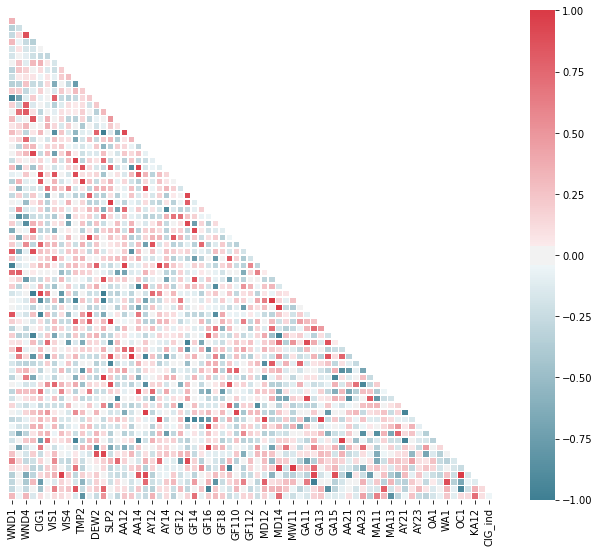

In [374]:
#plot the heatmap
import seaborn as sns
import matplotlib.pyplot as plt
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corrmatrix, mask=mask, cmap=cmap, linewidths=.5,yticklabels=False,vmax=1,vmin=-1)